In [2]:
import io
from urllib.request import urlopen, Request
import pandas as pd
import numpy as np

filename = 'https://gml.noaa.gov/aftp/data/radiation/surfrad/Bondville_IL/2010/bon10150.dat'
SURFRAD_COLUMNS = [
    'year', 'jday', 'month', 'day', 'hour', 'minute', 'dt', 'zen',
    'dw_solar', 'dw_solar_flag', 'uw_solar', 'uw_solar_flag', 'direct_n',
    'direct_n_flag', 'diffuse', 'diffuse_flag', 'dw_ir', 'dw_ir_flag',
    'dw_casetemp', 'dw_casetemp_flag', 'dw_dometemp', 'dw_dometemp_flag',
    'uw_ir', 'uw_ir_flag', 'uw_casetemp', 'uw_casetemp_flag', 'uw_dometemp',
    'uw_dometemp_flag', 'uvb', 'uvb_flag', 'par', 'par_flag', 'netsolar',
    'netsolar_flag', 'netir', 'netir_flag', 'totalnet', 'totalnet_flag',
    'temp', 'temp_flag', 'rh', 'rh_flag', 'windspd', 'windspd_flag',
    'winddir', 'winddir_flag', 'pressure', 'pressure_flag']

# Dictionary mapping surfrad variables to pvlib names
VARIABLE_MAP = {
    'zen': 'solar_zenith',
    'dw_solar': 'ghi',
    'dw_solar_flag': 'ghi_flag',
    'direct_n': 'dni',
    'direct_n_flag': 'dni_flag',
    'diffuse': 'dhi',
    'diffuse_flag': 'dhi_flag',
    'temp': 'temp_air',
    'temp_flag': 'temp_air_flag',
    'windspd': 'wind_speed',
    'windspd_flag': 'wind_speed_flag',
    'winddir': 'wind_direction',
    'winddir_flag': 'wind_direction_flag',
    'rh': 'relative_humidity',
    'rh_flag': 'relative_humidity_flag'
}


def read_surfrad(filename, map_variables=True):
    """Read in a daily NOAA SURFRAD file.  The SURFRAD network is
    described in [1]_.

    Parameters
    ----------
    filename: str
        Filepath or URL. URL can be either FTP or HTTP.
    map_variables: bool
        When true, renames columns of the Dataframe to pvlib variable names
        where applicable. See variable :const:`VARIABLE_MAP`.

    Returns
    -------
    Tuple of the form (data, metadata).

    data: Dataframe
        Dataframe with the fields found below.
    metadata: dict
        Site metadata included in the file.

    Notes
    -----
    Metadata dictionary includes the following fields:

    ===============  ======  ===============
    Key              Format  Description
    ===============  ======  ===============
    station          String  site name
    latitude         Float   site latitude
    longitude        Float   site longitude
    elevation        Int     site elevation
    surfrad_version  Int     surfrad version
    tz               String  Timezone (UTC)
    ===============  ======  ===============

    Dataframe includes the following fields:

    =======================  ======  ==========================================
    raw, mapped              Format  Description
    =======================  ======  ==========================================
    **Mapped field names are returned when the map_variables argument is True**
    ---------------------------------------------------------------------------
    year                     int     year as 4 digit int
    jday                     int     day of year 1-365(or 366)
    month                    int     month (1-12)
    day                      int     day of month(1-31)
    hour                     int     hour (0-23)
    minute                   int     minute (0-59)
    dt                       float   decimal time i.e. 23.5 = 2330
    zen, solar_zenith        float   solar zenith angle (deg)
    **Fields below have associated qc flags labeled <field>_flag.**
    ---------------------------------------------------------------------------
    dw_solar, ghi            float   downwelling global solar(W/m^2)
    uw_solar                 float   updownwelling global solar(W/m^2)
    direct_n, dni            float   direct normal solar (W/m^2)
    diffuse, dhi             float   downwelling diffuse solar (W/m^2)
    dw_ir                    float   downwelling thermal infrared (W/m^2)
    dw_casetemp              float   downwelling IR case temp (K)
    dw_dometemp              float   downwelling IR dome temp (K)
    uw_ir                    float   upwelling thermal infrared (W/m^2)
    uw_casetemp              float   upwelling IR case temp (K)
    uw_dometemp              float   upwelling IR case temp (K)
    uvb                      float   global uvb (miliWatts/m^2)
    par                      float   photosynthetically active radiation(W/m^2)
    netsolar                 float   net solar (dw_solar - uw_solar) (W/m^2)
    netir                    float   net infrared (dw_ir - uw_ir) (W/m^2)
    totalnet                 float   net radiation (netsolar+netir) (W/m^2)
    temp, temp_air           float   10-meter air temperature (?C)
    rh, relative_humidity    float   relative humidity (%)
    windspd, wind_speed      float   wind speed (m/s)
    winddir, wind_direction  float   wind direction (deg, clockwise from north)
    pressure                 float   station pressure (mb)
    =======================  ======  ==========================================

    See README files located in the station directories in the SURFRAD
    data archives [2]_ for details on SURFRAD daily data files. In addition to
    the FTP server, the SURFRAD files are also available via HTTP access [3]_.

    References
    ----------
    .. [1] NOAA Earth System Research Laboratory Surface Radiation Budget
       Network
       `SURFRAD Homepage <https://www.esrl.noaa.gov/gmd/grad/surfrad/>`_
    .. [2] NOAA SURFRAD Data Archive
       `SURFRAD Archive <ftp://aftp.cmdl.noaa.gov/data/radiation/surfrad/>`_
    .. [3] `NOAA SURFRAD HTTP Index
       <https://gml.noaa.gov/aftp/data/radiation/surfrad/>`_
    """
    if str(filename).startswith('ftp') or str(filename).startswith('http'):
        req = Request(filename)
        response = urlopen(req)
        file_buffer = io.StringIO(response.read().decode(errors='ignore'))
    else:
        file_buffer = open(str(filename), 'r')

    # Read and parse the first two lines to build the metadata dict.
    station = file_buffer.readline()
    file_metadata = file_buffer.readline()



    data = pd.read_csv(file_buffer, delim_whitespace=True,
                       header=None, names=SURFRAD_COLUMNS)
    file_buffer.close()

    data = _format_index(data)
    missing = data == -9999.9
    data = data.where(~missing, np.NaN)

    if map_variables:
        data.rename(columns=VARIABLE_MAP, inplace=True)
    return data


def _format_index(data):
    """Create UTC localized DatetimeIndex for the dataframe.

    Parameters
    ----------
    data: Dataframe
        Must contain columns 'year', 'jday', 'hour' and
        'minute'.

    Return
    ------
    data: Dataframe
        Dataframe with a DatetimeIndex localized to UTC.
    """
    year = data.year.apply(str)
    jday = data.jday.apply(lambda x: '{:03d}'.format(x))
    hours = data.hour.apply(lambda x: '{:02d}'.format(x))
    minutes = data.minute.apply(lambda x: '{:02d}'.format(x))
    index = pd.to_datetime(year + jday + hours + minutes, format="%Y%j%H%M")
    data.index = index
    data = data.tz_localize('UTC')
    return data

In [3]:
name1 = 'https://gml.noaa.gov/aftp/data/radiation/surfrad/Bondville_IL/2010/'
name2 = 'bon10001.dat'
name = name1 + name2
name

'https://gml.noaa.gov/aftp/data/radiation/surfrad/Bondville_IL/2010/bon10001.dat'

In [4]:
filename = name
data = read_surfrad(filename)
print(data)

                           year  jday  month  day  hour  minute      dt  \
2010-01-01 00:00:00+00:00  2010     1      1    1     0       0   0.000   
2010-01-01 00:01:00+00:00  2010     1      1    1     0       1   0.017   
2010-01-01 00:02:00+00:00  2010     1      1    1     0       2   0.033   
2010-01-01 00:03:00+00:00  2010     1      1    1     0       3   0.050   
2010-01-01 00:04:00+00:00  2010     1      1    1     0       4   0.067   
...                         ...   ...    ...  ...   ...     ...     ...   
2010-01-01 23:55:00+00:00  2010     1      1    1    23      55  23.917   
2010-01-01 23:56:00+00:00  2010     1      1    1    23      56  23.933   
2010-01-01 23:57:00+00:00  2010     1      1    1    23      57  23.950   
2010-01-01 23:58:00+00:00  2010     1      1    1    23      58  23.967   
2010-01-01 23:59:00+00:00  2010     1      1    1    23      59  23.983   

                           solar_zenith  ghi  ghi_flag  ...  temp_air  \
2010-01-01 00:00:00+00:00 

C:\Users\RGIPT\AppData\Local\Temp\ipykernel_14396\3222343631.py:140: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_buffer, delim_whitespace=True,


In [5]:
df1 = data

In [6]:
name1 = 'https://gml.noaa.gov/aftp/data/radiation/surfrad/Bondville_IL/2010/'
name2 = 'bon10002.dat'
name = name1 + name2
name

'https://gml.noaa.gov/aftp/data/radiation/surfrad/Bondville_IL/2010/bon10002.dat'

In [7]:
filename = name
data = read_surfrad(filename)
print(data)


                           year  jday  month  day  hour  minute      dt  \
2010-01-02 00:00:00+00:00  2010     2      1    2     0       0   0.000   
2010-01-02 00:01:00+00:00  2010     2      1    2     0       1   0.017   
2010-01-02 00:02:00+00:00  2010     2      1    2     0       2   0.033   
2010-01-02 00:03:00+00:00  2010     2      1    2     0       3   0.050   
2010-01-02 00:04:00+00:00  2010     2      1    2     0       4   0.067   
...                         ...   ...    ...  ...   ...     ...     ...   
2010-01-02 23:55:00+00:00  2010     2      1    2    23      55  23.917   
2010-01-02 23:56:00+00:00  2010     2      1    2    23      56  23.933   
2010-01-02 23:57:00+00:00  2010     2      1    2    23      57  23.950   
2010-01-02 23:58:00+00:00  2010     2      1    2    23      58  23.967   
2010-01-02 23:59:00+00:00  2010     2      1    2    23      59  23.983   

                           solar_zenith  ghi  ghi_flag  ...  temp_air  \
2010-01-02 00:00:00+00:00 

C:\Users\RGIPT\AppData\Local\Temp\ipykernel_14396\3222343631.py:140: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_buffer, delim_whitespace=True,


In [8]:
df2 = data

In [10]:
from bs4 import BeautifulSoup
import requests

url =  "https://gml.noaa.gov/aftp/data/radiation/surfrad/Bondville_IL/2010/"
page = requests.get(url)
soup = BeautifulSoup(page.text , 'html')
soup1 = soup

data = soup.find_all('td' , class_ = "indexcolname")

data_2010 = []

for i in data:

  data_2010.append(i.text.strip())

data_2010 = data_2010[2:]


In [11]:
name1 = 'https://gml.noaa.gov/aftp/data/radiation/surfrad/Bondville_IL/2010/'


In [ ]:
year =[2010,2011,2012,2013,2014,2015,2016]
for i in range(len(year)):

  url1 =  "https://gml.noaa.gov/aftp/data/radiation/surfrad/Bondville_IL/"
  new_url = url1 + str(year[i]) + "/"
  page = requests.get(new_url)
  soup = BeautifulSoup(page.text , 'html')
  soup1 = soup

  data = soup.find_all('td' , class_ = "indexcolname")

  data_year = []

  for i in data:
    data_year.append(i.text.strip())

  data_all = data_year[1:]
  for i in data_all:
    df_url = str(new_url) + str(i)
    filename = df_url
    data = read_surfrad(filename)
    df3 = data
    #result = df1.append(df2, ignore_index=True)
    #frames = [df1,df2]
    #result = pd.concat(frames)
    #result1 = df1 + df3
    
    df1 = pd.concat([df1, df3], ignore_index=True)

  print(data_all)
  data_year = []
  data_all =[]

data_all

In [13]:
df1.to_csv('NOAA_Dataset_2010_to_2016.csv', index=False)

In [14]:
import IPython.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
sns.set_theme(style='darkgrid')


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from pandas.tseries.offsets import DateOffset
from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")


In [15]:
dftrain = df1
dftest = df1
df1

year  jday  month  day  hour  minute      dt  solar_zenith  ghi  \
0        2010     1      1    1     0       0   0.000        105.07 -4.1   
1        2010     1      1    1     0       1   0.017        105.25 -4.1   
2        2010     1      1    1     0       2   0.033        105.44 -4.1   
3        2010     1      1    1     0       3   0.050        105.62 -4.1   
4        2010     1      1    1     0       4   0.067        105.80 -4.1   
...       ...   ...    ...  ...   ...     ...     ...           ...  ...   
2143523  2014    28      1   28    23      55  23.917         99.26 -3.1   
2143524  2014    28      1   28    23      56  23.933         99.44 -3.1   
2143525  2014    28      1   28    23      57  23.950         99.62 -3.2   
2143526  2014    28      1   28    23      58  23.967         99.81 -3.2   
2143527  2014    28      1   28    23      59  23.983         99.99 -3.2   

         ghi_flag  ...  temp_air  temp_air_flag  relative_humidity  \
0               0  ...      -8.9              0               75.9   
1               0  ...      -8.9              0               75.7   
2               0  ...      -8.9              0               75.7   
3               0  ...      -8.9              0               75.6   
4               0  ...      -8.9              0               75.8   
...           ...  ...       ...            ...                ...   
2143523         0  ...     -12.6              0               60.2   
2143524         0  ...     -12.5              0               59.6   
2143525         0  ...     -12.5              0               60.8   
2143526         0  ...     -12.6              0               61.5   
2143527         0  ...     -12.6              0               61.1   

         relative_humidity_flag  wind_speed  wind_speed_flag  wind_direction  \
0                             0         6.4                0           304.1   
1                             0         6.5                0           302.6   
2                             0         6.6                0           301.5   
3                             0         6.9                0           301.4   
4                             0         6.7                0           302.8   
...                         ...         ...              ...             ...   
2143523                       0         4.0                0           268.6   
2143524                       0         3.7                0           272.9   
2143525                       0         3.1                0           272.5   
2143526                       0         3.2                0           271.7   
2143527                       0         3.1                0           273.9   

         wind_direction_flag  pressure  pressure_flag  
0                          0     996.1              0  
1                          0     996.1              0  
2                          0     996.2              0  
3                          0     996.2              0  
4                          0     996.2              0  
...                      ...       ...            ...  
2143523                    0    1000.7              0  
2143524                    0    1000.7              0  
2143525                    0    1000.7              0  
2143526                    0    1000.7              0  
2143527                    0    1000.7              0  

[2143528 rows x 48 columns]

In [16]:
def format_index(data):
    """Create UTC localized DatetimeIndex for the dataframe.
    Parameters
    ----------
    data: Dataframe
        Must contain columns 'year', 'jday', 'hour' and
        'minute'.
    Return
    ------
    data: Dataframe
        Dataframe with a DatetimeIndex localized to UTC.
    """
    year = data.year.apply(str)
    jday = data.jday.apply(lambda x: '{:03d}'.format(x))
    hours = data.hour.apply(lambda x: '{:02d}'.format(x))
    minutes = data.minute.apply(lambda x: '{:02d}'.format(x))
    index = pd.to_datetime(year + jday + hours + minutes, format="%Y%j%H%M")
    data.index = index
    data = data.tz_localize('UTC')

    return data


In [17]:
df_train1 =format_index(dftrain)
df_test1 = format_index(dftest)

In [18]:
df_train1

year  jday  month  day  hour  minute      dt  \
2010-01-01 00:00:00+00:00  2010     1      1    1     0       0   0.000   
2010-01-01 00:01:00+00:00  2010     1      1    1     0       1   0.017   
2010-01-01 00:02:00+00:00  2010     1      1    1     0       2   0.033   
2010-01-01 00:03:00+00:00  2010     1      1    1     0       3   0.050   
2010-01-01 00:04:00+00:00  2010     1      1    1     0       4   0.067   
...                         ...   ...    ...  ...   ...     ...     ...   
2014-01-28 23:55:00+00:00  2014    28      1   28    23      55  23.917   
2014-01-28 23:56:00+00:00  2014    28      1   28    23      56  23.933   
2014-01-28 23:57:00+00:00  2014    28      1   28    23      57  23.950   
2014-01-28 23:58:00+00:00  2014    28      1   28    23      58  23.967   
2014-01-28 23:59:00+00:00  2014    28      1   28    23      59  23.983   

                           solar_zenith  ghi  ghi_flag  ...  temp_air  \
2010-01-01 00:00:00+00:00        105.07 -4.1         0  ...      -8.9   
2010-01-01 00:01:00+00:00        105.25 -4.1         0  ...      -8.9   
2010-01-01 00:02:00+00:00        105.44 -4.1         0  ...      -8.9   
2010-01-01 00:03:00+00:00        105.62 -4.1         0  ...      -8.9   
2010-01-01 00:04:00+00:00        105.80 -4.1         0  ...      -8.9   
...                                 ...  ...       ...  ...       ...   
2014-01-28 23:55:00+00:00         99.26 -3.1         0  ...     -12.6   
2014-01-28 23:56:00+00:00         99.44 -3.1         0  ...     -12.5   
2014-01-28 23:57:00+00:00         99.62 -3.2         0  ...     -12.5   
2014-01-28 23:58:00+00:00         99.81 -3.2         0  ...     -12.6   
2014-01-28 23:59:00+00:00         99.99 -3.2         0  ...     -12.6   

                           temp_air_flag  relative_humidity  \
2010-01-01 00:00:00+00:00              0               75.9   
2010-01-01 00:01:00+00:00              0               75.7   
2010-01-01 00:02:00+00:00              0               75.7   
2010-01-01 00:03:00+00:00              0               75.6   
2010-01-01 00:04:00+00:00              0               75.8   
...                                  ...                ...   
2014-01-28 23:55:00+00:00              0               60.2   
2014-01-28 23:56:00+00:00              0               59.6   
2014-01-28 23:57:00+00:00              0               60.8   
2014-01-28 23:58:00+00:00              0               61.5   
2014-01-28 23:59:00+00:00              0               61.1   

                           relative_humidity_flag  wind_speed  \
2010-01-01 00:00:00+00:00                       0         6.4   
2010-01-01 00:01:00+00:00                       0         6.5   
2010-01-01 00:02:00+00:00                       0         6.6   
2010-01-01 00:03:00+00:00                       0         6.9   
2010-01-01 00:04:00+00:00                       0         6.7   
...                                           ...         ...   
2014-01-28 23:55:00+00:00                       0         4.0   
2014-01-28 23:56:00+00:00                       0         3.7   
2014-01-28 23:57:00+00:00                       0         3.1   
2014-01-28 23:58:00+00:00                       0         3.2   
2014-01-28 23:59:00+00:00                       0         3.1   

                           wind_speed_flag  wind_direction  \
2010-01-01 00:00:00+00:00                0           304.1   
2010-01-01 00:01:00+00:00                0           302.6   
2010-01-01 00:02:00+00:00                0           301.5   
2010-01-01 00:03:00+00:00                0           301.4   
2010-01-01 00:04:00+00:00                0           302.8   
...                                    ...             ...   
2014-01-28 23:55:00+00:00                0           268.6   
2014-01-28 23:56:00+00:00                0           272.9   
2014-01-28 23:57:00+00:00                0           272.5   
2014-01-28 23:58:00+00:00                0           271.7   
2014-01-28 23:59:00+00:00    

In [19]:
df_train1.drop(columns=['year', 'month', 'day', 'minute', 'dt'], inplace=True)
df_test1.drop(columns=['year', 'month', 'day', 'minute', 'dt'], inplace=True)

In [20]:
df_train1

jday  hour  solar_zenith  ghi  ghi_flag  uw_solar  \
2010-01-01 00:00:00+00:00     1     0        105.07 -4.1         0       0.4   
2010-01-01 00:01:00+00:00     1     0        105.25 -4.1         0       0.4   
2010-01-01 00:02:00+00:00     1     0        105.44 -4.1         0       0.4   
2010-01-01 00:03:00+00:00     1     0        105.62 -4.1         0       0.4   
2010-01-01 00:04:00+00:00     1     0        105.80 -4.1         0       0.4   
...                         ...   ...           ...  ...       ...       ...   
2014-01-28 23:55:00+00:00    28    23         99.26 -3.1         0       0.5   
2014-01-28 23:56:00+00:00    28    23         99.44 -3.1         0      -0.3   
2014-01-28 23:57:00+00:00    28    23         99.62 -3.2         0       0.8   
2014-01-28 23:58:00+00:00    28    23         99.81 -3.2         0       0.5   
2014-01-28 23:59:00+00:00    28    23         99.99 -3.2         0       0.9   

                           uw_solar_flag  dni  dni_flag  dhi  ...  temp_air  \
2010-01-01 00:00:00+00:00              0  0.9         0 -0.3  ...      -8.9   
2010-01-01 00:01:00+00:00              0  0.9         0 -0.3  ...      -8.9   
2010-01-01 00:02:00+00:00              0  1.0         0 -0.2  ...      -8.9   
2010-01-01 00:03:00+00:00              0  0.9         0 -0.2  ...      -8.9   
2010-01-01 00:04:00+00:00              0  1.0         0 -0.3  ...      -8.9   
...                                  ...  ...       ...  ...  ...       ...   
2014-01-28 23:55:00+00:00              0  0.0         0  0.4  ...     -12.6   
2014-01-28 23:56:00+00:00              0  0.2         0  0.3  ...     -12.5   
2014-01-28 23:57:00+00:00              0  0.4         0  0.3  ...     -12.5   
2014-01-28 23:58:00+00:00              0  0.4         0  0.4  ...     -12.6   
2014-01-28 23:59:00+00:00              0  0.3         0  0.4  ...     -12.6   

                           temp_air_flag  relative_humidity  \
2010-01-01 00:00:00+00:00              0               75.9   
2010-01-01 00:01:00+00:00              0               75.7   
2010-01-01 00:02:00+00:00              0               75.7   
2010-01-01 00:03:00+00:00              0               75.6   
2010-01-01 00:04:00+00:00              0               75.8   
...                                  ...                ...   
2014-01-28 23:55:00+00:00              0               60.2   
2014-01-28 23:56:00+00:00              0               59.6   
2014-01-28 23:57:00+00:00              0               60.8   
2014-01-28 23:58:00+00:00              0               61.5   
2014-01-28 23:59:00+00:00              0               61.1   

                           relative_humidity_flag  wind_speed  \
2010-01-01 00:00:00+00:00                       0         6.4   
2010-01-01 00:01:00+00:00                       0         6.5   
2010-01-01 00:02:00+00:00                       0         6.6   
2010-01-01 00:03:00+00:00                       0         6.9   
2010-01-01 00:04:00+00:00                       0         6.7   
...                                           ...         ...   
2014-01-28 23:55:00+00:00                       0         4.0   
2014-01-28 23:56:00+00:00                       0         3.7   
2014-01-28 23:57:00+00:00                       0         3.1   
2014-01-28 23:58:00+00:00                       0         3.2   
2014-01-28 23:59:00+00:00                       0         3.1   

                           wind_speed_flag  wind_direction  \
2010-01-01 00:00:00+00:00                0           304.1   
2010-01-01 00:01:00+00:00                0           302.6   
2010-01-01 00:02:00+00:00                0           301.5   
2010-01-01 00:03:00+00:00                0           301.4   
2010-01-01 00:04:00+00:00                0           302.8   
...                                    ...             ...   
2014-01-28 23:55:00+00:00                0           268.6   
2014-01-28 23:56:00+00:00                0           272.9   
2014-01-28 23:57:00+0

In [21]:
# Quick and dirty interpolation to replace nan values
df_train1.interpolate(method='linear', inplace=True)
df_test1.interpolate(method='linear', inplace=True)

In [22]:
# Sanity check for datetime index
df_test1.index.hour

Index([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       ...
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23],
      dtype='int32', length=2143528)

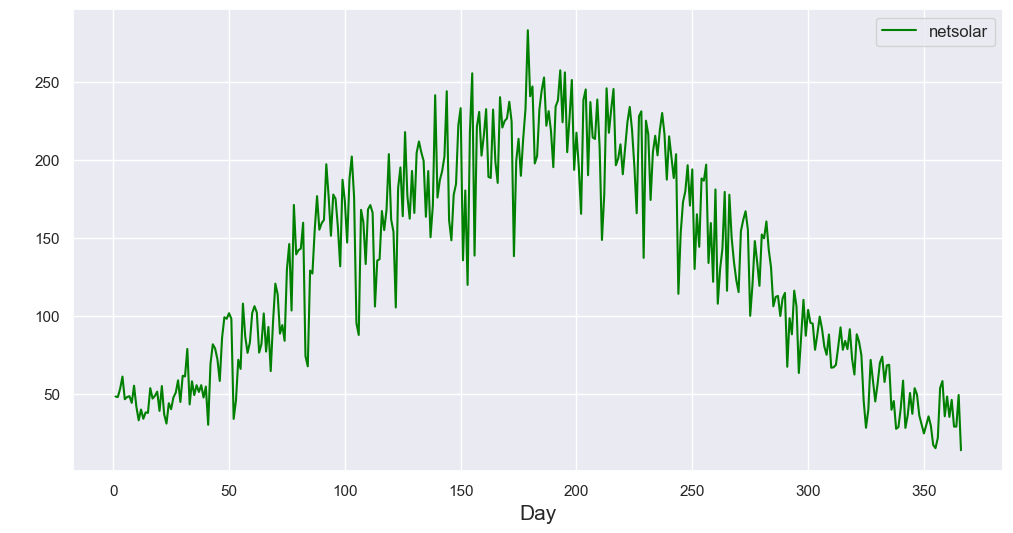

In [23]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_train1.groupby('jday').mean(), x='jday', y='netsolar', color='green')

plt.xlabel('Day', fontsize=15)
plt.ylabel(' ', fontsize=15)
plt.legend(['netsolar'], fontsize=12)
# plt.title('Total Solar Radiation for Julian day 1 of 2020', fontsize=20)
plt.show();

In [24]:
# Checking null values across all the dataframes
null_dict = {}
null_dict['Bondville_IL'] = df_train1.isna().sum()
df_null = pd.DataFrame(null_dict)
df_null

Bondville_IL
jday                               0
hour                               0
solar_zenith                       0
ghi                                0
ghi_flag                           0
uw_solar                           0
uw_solar_flag                      0
dni                                0
dni_flag                           0
dhi                                0
dhi_flag                           0
dw_ir                              0
dw_ir_flag                         0
dw_casetemp                        0
dw_casetemp_flag                   0
dw_dometemp                        0
dw_dometemp_flag                   0
uw_ir                              0
uw_ir_flag                         0
uw_casetemp                        0
uw_casetemp_flag                   0
uw_dometemp                        0
uw_dometemp_flag                   0
uvb                                0
uvb_flag                           0
par                                0
par_flag                           0
netsolar                           0
netsolar_flag                      0
netir                              0
netir_flag                         0
totalnet                           0
totalnet_flag                      0
temp_air                           0
temp_air_flag                      0
relative_humidity                  0
relative_humidity_flag             0
wind_speed                         0
wind_speed_flag                    0
wind_direction                     0
wind_direction_flag                0
pressure                           0
pressure_flag                      0

In [25]:
location = 'Bondville_IL'
def data_split(df_train, df_test, location, frequency):
    '''
    Simple function to split data into training/test/validation set
    Also, split based on hourly/daily/monthly aggregates
    '''
    if frequency == 'hourly':
        train = df_train.resample('H').mean()
        test_split = int((df_test.resample('H').mean().shape[0])/2)
        val = df_test.resample('H').mean()[0:test_split]
        test = df_test.resample('H').mean()[test_split:]

    elif frequency=='daily':
        train = df_train.resample('D').mean()
        test_split = int((df_test.resample('D').mean().shape[0])/2)
        val = df_test.resample('D').mean()[0:test_split]
        test = df_test.resample('D').mean()[test_split:]

    elif frequency=='monthly':
        train = df_train.resample('MS').mean()
        test_split = int((df_test.resample('MS').mean().shape[0])/2)
        val = df_test.resample('MS').mean()[0:test_split]
        test = df_test.resample('MS').mean()[test_split:]

    return train, val, test

In [26]:
# split with daily aggregate
train_d, val_d, test_d = {}, {}, {}

train_d[location], val_d[location], test_d[location] = data_split(df_train1, df_test1, location, frequency='daily')


# split with hourly aggregate
train_h, val_h, test_h = {}, {}, {}

train_h[location], val_h[location], test_h[location] = data_split(df_train1, df_test1, location, frequency='hourly')

In [27]:
train_h[location]

jday  hour  solar_zenith         ghi  ghi_flag  \
2010-01-01 00:00:00+00:00   1.0   0.0    110.523667   -4.100000       0.0   
2010-01-01 01:00:00+00:00   1.0   1.0    121.836833   -4.100000       0.0   
2010-01-01 02:00:00+00:00   1.0   2.0    133.285833   -4.100000       0.0   
2010-01-01 03:00:00+00:00   1.0   3.0    144.501833   -4.105000       0.0   
2010-01-01 04:00:00+00:00   1.0   4.0    154.695333   -4.070000       0.0   
...                         ...   ...           ...         ...       ...   
2014-01-28 19:00:00+00:00  28.0  19.0     61.298167  516.775000       0.0   
2014-01-28 20:00:00+00:00  28.0  20.0     66.959833  298.221667       0.0   
2014-01-28 21:00:00+00:00  28.0  21.0     74.786000  229.218333       0.0   
2014-01-28 22:00:00+00:00  28.0  22.0     84.054833   66.920000       0.0   
2014-01-28 23:00:00+00:00  28.0  23.0     94.562333   -1.561667       0.0   

                             uw_solar  uw_solar_flag         dni  dni_flag  \
2010-01-01 00:00:00+00:00    0.300000            0.0    1.133333       0.0   
2010-01-01 01:00:00+00:00    0.140000            0.0    1.128333       0.0   
2010-01-01 02:00:00+00:00    0.161667            0.0    1.316667       0.0   
2010-01-01 03:00:00+00:00    0.101667            0.0    1.358333       0.0   
2010-01-01 04:00:00+00:00    0.175000            0.0    1.451667       0.0   
...                               ...            ...         ...       ...   
2014-01-28 19:00:00+00:00  140.813333            0.0  836.915000       0.0   
2014-01-28 20:00:00+00:00   84.231667            0.0  441.228333       0.0   
2014-01-28 21:00:00+00:00   73.001667            0.0  605.071667       0.0   
2014-01-28 22:00:00+00:00   27.495000            0.0  373.490000       0.0   
2014-01-28 23:00:00+00:00    1.391667            0.0   12.548333       0.0   

                                  dhi  ...   temp_air  temp_air_flag  \
2010-01-01 00:00:00+00:00   -0.253333  ...  -9.303333            0.0   
2010-01-01 01:00:00+00:00   -0.218333  ...  -9.995000            0.0   
2010-01-01 02:00:00+00:00   -0.210000  ... -10.710000            0.0   
2010-01-01 03:00:00+00:00   -0.210000  ... -11.341667            0.0   
2010-01-01 04:00:00+00:00   -0.205000  ... -12.006667            0.0   
...                               ...  ...        ...            ...   
2014-01-28 19:00:00+00:00  113.548333  ... -12.718333            0.0   
2014-01-28 20:00:00+00:00  131.483333  ... -12.263333            0.0   
2014-01-28 21:00:00+00:00   81.400000  ... -11.541667            0.0   
2014-01-28 22:00:00+00:00   32.628333  ... -11.395000            0.0   
2014-01-28 23:00:00+00:00    2.198333  ... -12.101667            0.0   

                           relative_humidity  relative_humidity_flag  \
2010-01-01 00:00:00+00:00          76.533333                     0.0   
2010-01-01 01:00:00+00:00          76.276667                     0.0   
2010-01-01 02:00:00+00:00          75.970000                     0.0   
2010-01-01 03:00:00+00:00          76.918333                     0.0   
2010-01-01 04:00:00+00:00          79.565000                     0.0   
...                                      ...                     ...   
2014-01-28 19:00:00+00:00          57.225000                     0.0   
2014-01-28 20:00:00+00:00          56.056667                     0.0   
2014-01-28 21:00:00+00:00          53.066667                     0.0   
2014-01-28 22:00:00+00:00          52.858333                     0.0   
2014-01-28 23:00:00+00:00          57.970000                     0.0   

                           wind_speed  wind_speed_flag  wind_direction  \
2010-01-01 00:00:00+00:00    6.331667              0.0      302.641667   
2010-01-01 01:00:00+00:00    6.720000              0.0      303.390000   
2010-01-01 02:00:00+00:00    5.961667              0.0      302.925000   
2010-01-01 03:00:00+00:00    5.888333              0.0      298.753333   
2010-01-01 04:00:00+00:00    5.511667              0.0      297.1

In [28]:
train_h[location]['netsolar'].max()

868.4916666666667

In [29]:
train_h[location]['netsolar'].min()

0.0

In [30]:
train_h[location]['netsolar']

2010-01-01 00:00:00+00:00      0.000000
2010-01-01 01:00:00+00:00      0.000000
2010-01-01 02:00:00+00:00      0.000000
2010-01-01 03:00:00+00:00      0.000000
2010-01-01 04:00:00+00:00      0.000000
                                ...    
2014-01-28 19:00:00+00:00    376.038333
2014-01-28 20:00:00+00:00    218.455000
2014-01-28 21:00:00+00:00    166.220000
2014-01-28 22:00:00+00:00     49.366667
2014-01-28 23:00:00+00:00      1.051667
Freq: h, Name: netsolar, Length: 35736, dtype: float64

In [31]:
# Create a univariate sequence for modelling
'''
We chose "netsolar" attributes as our target sequence
'''
train_d_uni, val_d_uni, test_d_uni = {}, {}, {}

train_d_uni[location] = train_d[location][['netsolar']]
val_d_uni[location] = val_d[location][['netsolar']]
test_d_uni[location] = test_d[location][['netsolar']]

In [32]:
train_d_uni[location]['netsolar'].min()

5.550833333333333

In [33]:
train_d_uni[location]['netsolar'].max()

294.8012847222222

In [34]:
train_d_uni[location]

netsolar
2010-01-01 00:00:00+00:00   47.352778
2010-01-02 00:00:00+00:00   51.053889
2010-01-03 00:00:00+00:00   50.267639
2010-01-04 00:00:00+00:00   40.505208
2010-01-05 00:00:00+00:00   41.850069
...                               ...
2014-01-24 00:00:00+00:00   36.531458
2014-01-25 00:00:00+00:00   57.851597
2014-01-26 00:00:00+00:00   53.156944
2014-01-27 00:00:00+00:00   89.449861
2014-01-28 00:00:00+00:00  103.411597

[1489 rows x 1 columns]

In [35]:
# for hourly set
train_h_uni, val_h_uni, test_h_uni = {}, {}, {}

train_h_uni[location] = train_h[location][['netsolar']]
val_h_uni[location] = val_h[location][['netsolar']]
test_h_uni[location] = test_h[location][['netsolar']]

In [36]:
train_h_uni[location]['netsolar'].max()

868.4916666666667

In [37]:
train_d_1d = train_d_uni['Bondville_IL']
val_d_1d = val_d_uni['Bondville_IL']
test_d_1d = test_d_uni['Bondville_IL']
train_d_1d.shape, val_d_1d.shape, test_d_1d.shape

((1489, 1), (744, 1), (745, 1))

In [38]:
# Create univariate set for hourly average
train_h_1d = train_h_uni['Bondville_IL']
val_h_1d = val_h_uni['Bondville_IL']
test_h_1d = test_h_uni['Bondville_IL']
train_h_1d.shape, val_h_1d.shape, test_h_1d.shape

((35736, 1), (17868, 1), (17868, 1))

In [39]:
train_h_1d['netsolar']

2010-01-01 00:00:00+00:00      0.000000
2010-01-01 01:00:00+00:00      0.000000
2010-01-01 02:00:00+00:00      0.000000
2010-01-01 03:00:00+00:00      0.000000
2010-01-01 04:00:00+00:00      0.000000
                                ...    
2014-01-28 19:00:00+00:00    376.038333
2014-01-28 20:00:00+00:00    218.455000
2014-01-28 21:00:00+00:00    166.220000
2014-01-28 22:00:00+00:00     49.366667
2014-01-28 23:00:00+00:00      1.051667
Freq: h, Name: netsolar, Length: 35736, dtype: float64

In [40]:
data_new = train_h_1d['netsolar']
data_new

2010-01-01 00:00:00+00:00      0.000000
2010-01-01 01:00:00+00:00      0.000000
2010-01-01 02:00:00+00:00      0.000000
2010-01-01 03:00:00+00:00      0.000000
2010-01-01 04:00:00+00:00      0.000000
                                ...    
2014-01-28 19:00:00+00:00    376.038333
2014-01-28 20:00:00+00:00    218.455000
2014-01-28 21:00:00+00:00    166.220000
2014-01-28 22:00:00+00:00     49.366667
2014-01-28 23:00:00+00:00      1.051667
Freq: h, Name: netsolar, Length: 35736, dtype: float64

In [41]:
data_new[5]

0.0

In [42]:
np.max(train_h_1d)

868.4916666666667

In [43]:
# Apply a scalar for faster training

scaler_d = MinMaxScaler()
scaler_d.fit(train_d_1d)
train_d_scaled = scaler_d.transform(train_d_1d)
val_d_scaled = scaler_d.transform(val_d_1d)
test_d_scaled = scaler_d.transform(test_d_1d)

In [44]:
# @title Default title text
# Apply a scalar for faster training

scaler_h = MinMaxScaler()
x=scaler_h.fit(train_h_1d)
train_h_scaled = x.transform(train_h_1d)
val_h_scaled = x.transform(val_h_1d)
test_h_scaled = scaler_h.transform(test_h_1d)

In [45]:
# Check for NaN values
nan_indices = np.isnan(val_h_scaled)

# # Count the number of NaN values
num_nan_values = np.sum(nan_indices)
num_nan_values
# Create a boolean mask for NaN values

13

In [46]:
# Check for NaN values
# nan_indices = np.isnan(train_h_scaled)

# # Count the number of NaN values
# num_nan_values = np.sum(nan_indices)
# num_nan_values
# Create a boolean mask for NaN values
nan_mask = np.isnan(train_h_scaled)

# Use the mask to index the array and remove NaN values
arr_no_nan = train_h_scaled[~nan_mask]

# Print the results
print("Original Array:")
# print()
# print("\nArray without NaN Values:")
# print(arr_no_nan)
train_h_scaled_24 = arr_no_nan

Original Array:


In [47]:
np.max(arr_no_nan)


0.9999999999999999

In [48]:
nan_mask = np.isnan(val_h_scaled)

# Use the mask to index the array and remove NaN values
arr_no_nan = val_h_scaled[~nan_mask]

# Print the results
print("Original Array:")
# print()
# print("\nArray without NaN Values:")
# print(arr_no_nan)
val_h_scaled_24 = arr_no_nan

Original Array:


In [49]:
nan_mask = np.isnan(test_h_scaled)

# Use the mask to index the array and remove NaN values
arr_no_nan = test_h_scaled[~nan_mask]

# Print the results
print("Original Array:")
# print()
# print("\nArray without NaN Values:")
# print(arr_no_nan)
test_h_scaled_24 = arr_no_nan

Original Array:


In [50]:
train_h_scaled_24.shape, val_h_scaled_24.shape, test_h_scaled_24.shape

((35703,), (17855,), (17848,))

In [51]:
train_d_scaled.shape, val_d_scaled.shape, test_d_scaled.shape

((1489, 1), (744, 1), (745, 1))

In [52]:
from numpy import array

def split_seq(sequence, n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        # find end of this pattern
        end_ix = i + n_steps


        # check if ware beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

In [53]:
# Unit test
train_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
test_seq = [13, 14, 15, 16, 17]

X_train_t, y_train_t = split_seq(train_seq, n_steps=3)
X_test_t, y_test_t = split_seq(test_seq, n_steps=3)
print(X_train_t[0], y_train_t[0])

[10 20 30] 40


In [54]:
X_train_t

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60],
       [50, 60, 70],
       [60, 70, 80]])

In [55]:
y_train_t

array([40, 50, 60, 70, 80, 90])

In [56]:
# Create data split with a lag of 10
X_train_10, y_train_10 = split_seq(train_d_scaled, n_steps=10)
X_val_10, y_val_10 = split_seq(val_d_scaled, n_steps=10)
X_test_10, y_test_10 = split_seq(test_d_scaled, n_steps=10)

X_train_10.shape, y_train_10.shape, X_test_10.shape, y_test_10.shape, X_val_10.shape, y_val_10.shape

((1479, 10, 1), (1479, 1), (735, 10, 1), (735, 1), (734, 10, 1), (734, 1))

In [57]:
# Create data split with a lag of 30
X_train_30, y_train_30 = split_seq(train_d_scaled, n_steps=30)
X_val_30, y_val_30 = split_seq(val_d_scaled, n_steps=30)
X_test_30, y_test_30 = split_seq(test_d_scaled, n_steps=30)

X_train_30.shape, y_train_30.shape, X_test_30.shape, y_test_30.shape, X_val_30.shape, y_val_30.shape

((1459, 30, 1), (1459, 1), (715, 30, 1), (715, 1), (714, 30, 1), (714, 1))

In [58]:
# Create data split with a lag of 24hr
X_train_24, y_train_24 = split_seq(train_h_scaled_24, n_steps=24)
X_val_24, y_val_24 = split_seq(val_h_scaled_24, n_steps=24)
X_test_24, y_test_24 = split_seq(test_h_scaled_24, n_steps=24)

X_train_24.shape, y_train_24.shape, X_test_24.shape, y_test_24.shape, X_val_24.shape, y_val_24.shape

((35679, 24), (35679,), (17824, 24), (17824,), (17831, 24), (17831,))

**24 hour prediction**

In [59]:
X_train_24

array([[0.        , 0.        , 0.        , ..., 0.06522227, 0.00643453,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00643453, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14748175, 0.04229555, 0.00055844, ..., 0.49292356, 0.43297863,
        0.25153379],
       [0.04229555, 0.00055844, 0.        , ..., 0.43297863, 0.25153379,
        0.19138929],
       [0.00055844, 0.        , 0.        , ..., 0.25153379, 0.19138929,
        0.05684184]])

In [60]:
def plot_loss(history, val_data):

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=hist['epoch'],
                            y=hist['loss'],
                            name='Training Loss'),
                         )
    if val_data == True:
        fig.add_trace(go.Scatter(x=hist['epoch'],
                        y=hist['val_loss'],
                        name='Val Loss')
             )

    fig.update_layout(title='Training Result')
    fig.show()

In [61]:
def run_model(model, X_train, y_train, X_val, y_val, epochs):
    batch_size =10
    es =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), callbacks=es,
                    epochs=epochs, batch_size=batch_size, verbose=2)
    #IPython.display.clear_output()
    return history, model

In [81]:
n_steps = 24
n_features=1

modelh = Sequential()
modelh.add(layers.LSTM(100, activation='relu',
                          input_shape=(n_steps, n_features),
                          return_sequences=True))
modelh.add(layers.LSTM(50, activation='relu'))
modelh.add(layers.Dense(1))
modelh.compile(loss='mean_squared_error', optimizer='adam')
print(modelh.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100
4529/4529 - 41s - 9ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 2/100
4529/4529 - 38s - 8ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 3/100
4529/4529 - 39s - 9ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 4/100
4529/4529 - 39s - 9ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/100
4529/4529 - 38s - 8ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 6/100
4529/4529 - 38s - 8ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/100
4529/4529 - 38s - 8ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/100
4529/4529 - 42s - 9ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 9/100
4529/4529 - 43s - 9ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/100
4529/4529 - 41s - 9ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 11/100
4529/4529 - 39s - 9ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 12/100
4529/4529 - 40s - 9ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 13/100
4529/4529 - 41s - 9ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 14/100
4529/4529 - 40s - 9ms/step - loss:

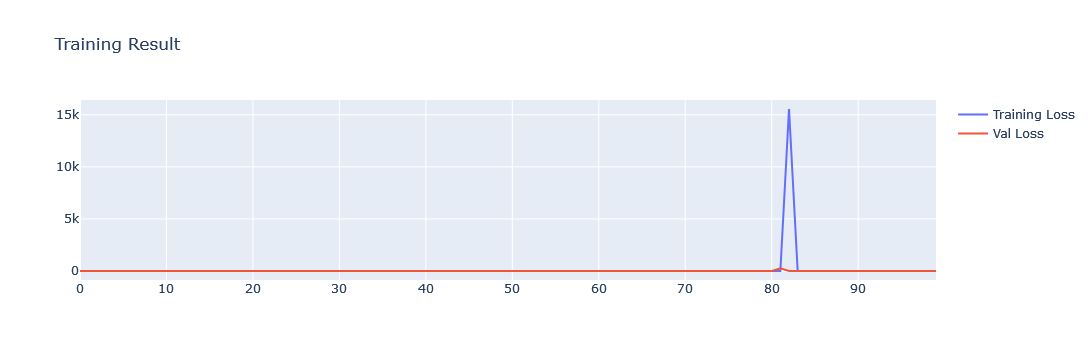

In [82]:
historyh, modelh = run_model(modelh, X_train_24, y_train_24, X_val_24, y_val_24, epochs=100)
plot_loss(historyh, val_data=True)

In [83]:
y_predh=modelh.predict(X_val_24)

708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [84]:
from sklearn.metrics import r2_score
r2_score(y_val_24, y_predh)

0.9626776993279224

In [ ]:
modelh.save('models/modelh.h5')

**LSTM with 10 days look back**

In [86]:
# We will start witha a Simple LSTM
n_steps = 10
n_features=1

model1 = Sequential()
model1.add(layers.LSTM(10, activation='relu', input_shape=(n_steps, n_features)))
model1.add(layers.Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
print(model1.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

None


In [87]:
batch_size =10
es =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model1.fit(X_train_10, y_train_10,
                validation_data=(X_val_10, y_val_10), callbacks=es,
                epochs=5, batch_size=batch_size, verbose=2)
#IPython.display.clear_output()

Epoch 1/5
188/188 - 2s - 9ms/step - loss: 0.0920 - val_loss: 0.0334
Epoch 2/5
188/188 - 0s - 2ms/step - loss: 0.0347 - val_loss: 0.0328
Epoch 3/5
188/188 - 0s - 2ms/step - loss: 0.0340 - val_loss: 0.0317
Epoch 4/5
188/188 - 0s - 2ms/step - loss: 0.0332 - val_loss: 0.0311
Epoch 5/5
188/188 - 0s - 2ms/step - loss: 0.0325 - val_loss: 0.0345


In [88]:
def plot_loss(history, val_data):

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=hist['epoch'],
                            y=hist['loss'],
                            name='Training Loss'),
                         )
    if val_data == True:
        fig.add_trace(go.Scatter(x=hist['epoch'],
                        y=hist['val_loss'],
                        name='Val Loss')
             )

    fig.update_layout(title='Training Result')
    fig.show()

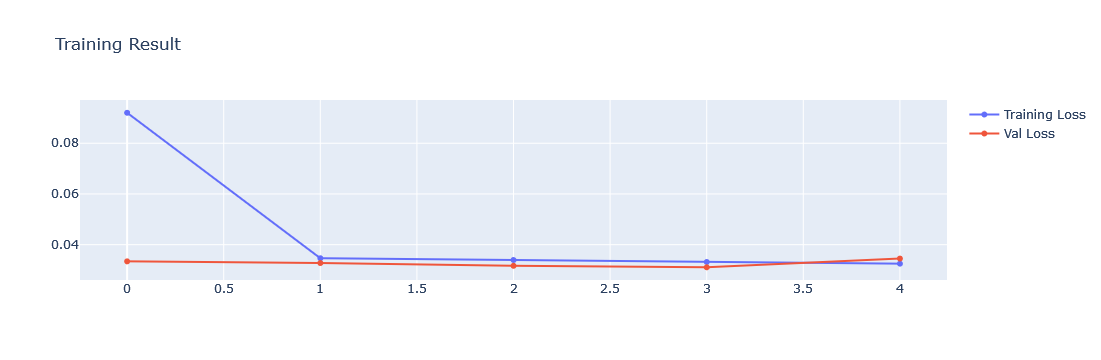

In [89]:
plot_loss(history, val_data=True)

This was not a bad performance at all, given the few iterations! Nonetheless, we will try to further optimize the model with increasing lstm cells and number of epochs to 50

In [90]:
# We will increase the LSTM layer and also the number of epochs.
n_steps = 10
n_features=1
model2 = Sequential()
model2.add(layers.LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model2.add(layers.Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
print(model2.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None


In [91]:
def run_model(model, X_train, y_train, X_val, y_val, epochs):
    batch_size =10
    es =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), callbacks=es,
                    epochs=epochs, batch_size=batch_size, verbose=2)
    #IPython.display.clear_output()
    return history, model

Epoch 1/50
188/188 - 2s - 8ms/step - loss: 0.0520 - val_loss: 0.0305
Epoch 2/50
188/188 - 0s - 2ms/step - loss: 0.0324 - val_loss: 0.0296
Epoch 3/50
188/188 - 0s - 2ms/step - loss: 0.0318 - val_loss: 0.0296
Epoch 4/50
188/188 - 0s - 2ms/step - loss: 0.0314 - val_loss: 0.0291
Epoch 5/50
188/188 - 0s - 2ms/step - loss: 0.0312 - val_loss: 0.0284
Epoch 6/50
188/188 - 0s - 2ms/step - loss: 0.0309 - val_loss: 0.0282
Epoch 7/50
188/188 - 0s - 3ms/step - loss: 0.0306 - val_loss: 0.0279
Epoch 8/50
188/188 - 0s - 2ms/step - loss: 0.0301 - val_loss: 0.0282
Epoch 9/50
188/188 - 0s - 2ms/step - loss: 0.0298 - val_loss: 0.0308
Epoch 10/50
188/188 - 0s - 2ms/step - loss: 0.0298 - val_loss: 0.0275
Epoch 11/50
188/188 - 0s - 2ms/step - loss: 0.0298 - val_loss: 0.0275
Epoch 12/50
188/188 - 0s - 2ms/step - loss: 0.0302 - val_loss: 0.0272
Epoch 13/50
188/188 - 0s - 2ms/step - loss: 0.0295 - val_loss: 0.0278
Epoch 14/50
188/188 - 0s - 2ms/step - loss: 0.0292 - val_loss: 0.0273
Epoch 15/50
188/188 - 0s - 2m

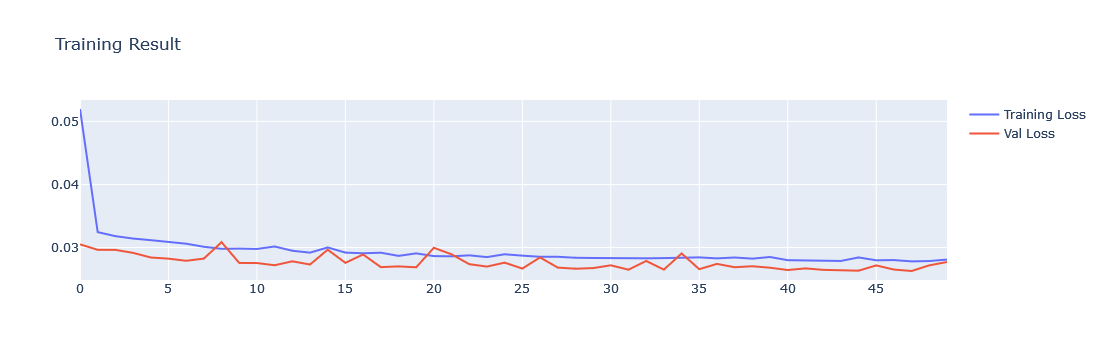

In [92]:
history2, model2 = run_model(model2, X_train_10, y_train_10, X_val_10, y_val_10, epochs=50)
plot_loss(history2, val_data=True)

In [93]:
testPredict = model2.predict(X_test_10, batch_size=batch_size)
testPredict = scaler_d.inverse_transform(testPredict)

trainPredict = model2.predict(X_train_10, batch_size=batch_size)
trainPredict = scaler_d.inverse_transform(trainPredict)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


In [94]:
y_pred1=model2.predict(X_val_10)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [95]:
from sklearn.metrics import r2_score
r2_score(y_val_10, y_pred1)

0.6618510087340947

In [96]:
def create_pred_df(true_series, prediction):

    df_temp = pd.DataFrame(true_series, columns=['netsolar']).reset_index()
    predicted_series = pd.Series(prediction.reshape(-1))
    df_temp['predicted'] = pd.Series(predicted_series, index = df_temp.index)

    df_pred = pd.DataFrame(true_series, columns=['netsolar'])
    df_pred['predicted'] = df_temp['predicted'].values

    return df_pred

In [97]:
df_pred_test = create_pred_df(test_d_1d, testPredict)
df_pred_train = create_pred_df(train_d_1d, trainPredict)

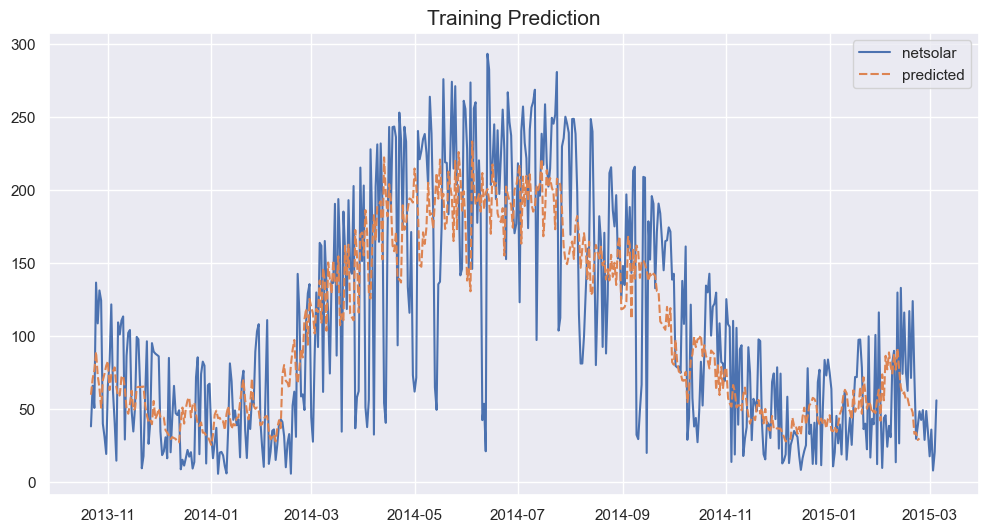

In [98]:
# Training Prediction
plt.figure(figsize=(12,6))
sns.lineplot(data=df_pred_train[-500:])
plt.title('Training Prediction', fontsize=15)
plt.legend()
plt.show();

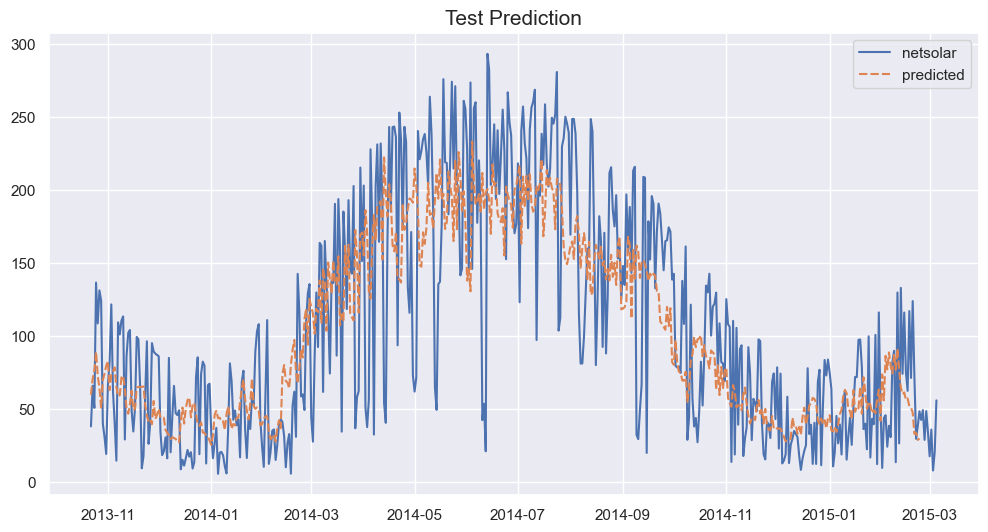

In [99]:
# Test Prediction
plt.figure(figsize=(12,6))
sns.lineplot(data=df_pred_test[-500:])
plt.title('Test Prediction', fontsize=15)
plt.legend()
plt.show();

In [ ]:
model2.save('models/model2.h5')

In [ ]:
# Test loading model
model2_lag10 = load_model('models/model2.h5')

In [102]:
testPredict = model2_lag10.predict(X_test_10, batch_size=batch_size)
testPredict = scaler_d.inverse_transform(testPredict)

trainPredict = model2_lag10.predict(X_train_10, batch_size=batch_size)
trainPredict = scaler_d.inverse_transform(trainPredict)

df_pred_test2 = create_pred_df(test_d_1d, testPredict)
df_pred_train2 = create_pred_df(train_d_1d, trainPredict)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


In [103]:
# Now we will increase the # lstm cells to 100 in the first layer
# and also add another lstm layer with 50 cells
# Finally, we will run this model for 100 iterations.

n_steps = 10
n_features=1

model3 = Sequential()
model3.add(layers.LSTM(100, activation='relu',
                          input_shape=(n_steps, n_features),
                          return_sequences=True))
model3.add(layers.LSTM(50, activation='relu'))
model3.add(layers.Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
print(model3.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 10, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100
188/188 - 3s - 14ms/step - loss: 0.0453 - val_loss: 0.0335
Epoch 2/100
188/188 - 1s - 4ms/step - loss: 0.0341 - val_loss: 0.0316
Epoch 3/100
188/188 - 1s - 4ms/step - loss: 0.0338 - val_loss: 0.0396
Epoch 4/100
188/188 - 1s - 4ms/step - loss: 0.0327 - val_loss: 0.0298
Epoch 5/100
188/188 - 1s - 4ms/step - loss: 0.0318 - val_loss: 0.0285
Epoch 6/100
188/188 - 1s - 4ms/step - loss: 0.0313 - val_loss: 0.0305
Epoch 7/100
188/188 - 1s - 4ms/step - loss: 0.0306 - val_loss: 0.0282
Epoch 8/100
188/188 - 1s - 4ms/step - loss: 0.0305 - val_loss: 0.0280
Epoch 9/100
188/188 - 1s - 4ms/step - loss: 0.0298 - val_loss: 0.0275
Epoch 10/100
188/188 - 1s - 4ms/step - loss: 0.0298 - val_loss: 0.0273
Epoch 11/100
188/188 - 1s - 4ms/step - loss: 0.0300 - val_loss: 0.0271
Epoch 12/100
188/188 - 1s - 4ms/step - loss: 0.0291 - val_loss: 0.0282
Epoch 13/100
188/188 - 1s - 4ms/step - loss: 0.0292 - val_loss: 0.0281
Epoch 14/100
188/188 - 1s - 4ms/step - loss: 0.0290 - val_loss: 0.0272
Epoch 15/100
1

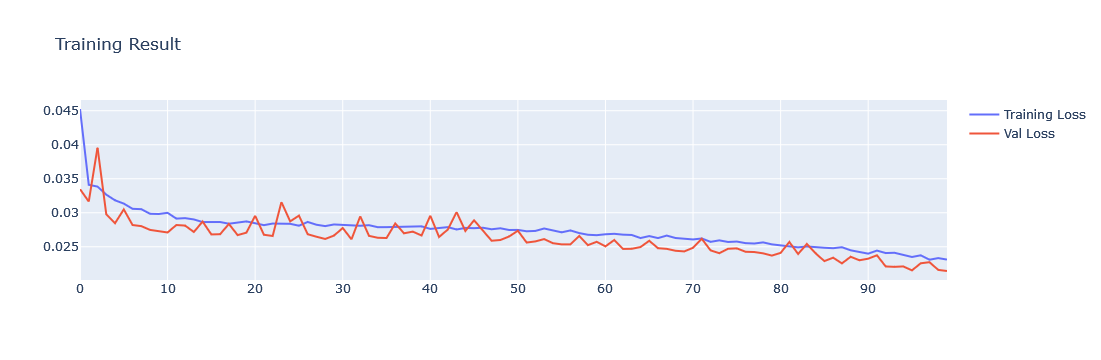

In [104]:
history3, model3 = run_model(model3, X_train_10, y_train_10, X_val_10, y_val_10, epochs=100)
plot_loss(history3, val_data=True)

In [105]:
testPredict3 = model3.predict(X_test_10, batch_size=10)
testPredict3 = scaler_d.inverse_transform(testPredict3)

trainPredict3 = model3.predict(X_train_10, batch_size=10)
trainPredict3 = scaler_d.inverse_transform(trainPredict3)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [106]:
df_pred_test3 = create_pred_df(test_d_1d, testPredict3)
df_pred_train3 = create_pred_df(train_d_1d, trainPredict3)

In [107]:
df_pred_test3.head()

netsolar   predicted
2012-08-03 00:00:00+00:00  252.542014  203.349869
2012-08-04 00:00:00+00:00  212.815069  169.672852
2012-08-05 00:00:00+00:00  259.805764  219.786987
2012-08-06 00:00:00+00:00  272.839444  181.547150
2012-08-07 00:00:00+00:00  261.639514  173.531845

In [108]:
mae_train_lstm_lag10 = mean_absolute_error(df_pred_train3['netsolar'], df_pred_train3['predicted'].fillna(0))
mae_test_lstm_lag10 = mean_absolute_error(df_pred_test3['netsolar'], df_pred_test3['predicted'].fillna(0))

print(f'Training Mean Absolute Error LSTM with lag 10: {mae_train_lstm_lag10}')
print(f'Test Mean Absolute Error LSTM with lag 10: {mae_test_lstm_lag10}')

Training Mean Absolute Error LSTM with lag 10: 43.373370057647186
Test Mean Absolute Error LSTM with lag 10: 44.61443151384212


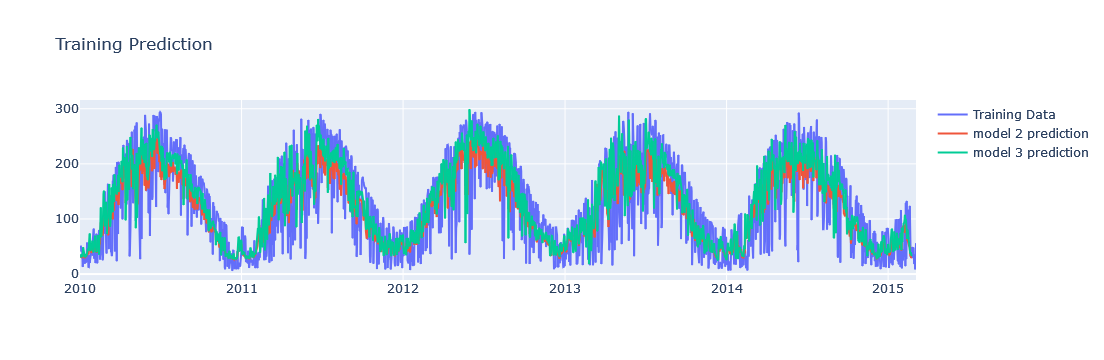

In [109]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_pred_train2.index,
                        y=df_pred_train2.netsolar,
                        name='Training Data'),
                     )

fig.add_trace(go.Scatter(x=df_pred_train2.index,
                        y=df_pred_train2.predicted,
                        name='model 2 prediction'),
                     )

fig.add_trace(go.Scatter(x=df_pred_train3.index,
                        y=df_pred_train3.predicted,
                        name='model 3 prediction'),
                     )

fig.update_layout(title='Training Prediction')
fig.show()

In [110]:
y_pred2=model3.predict(X_val_10)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [111]:
from sklearn.metrics import r2_score
r2_score(y_val_10, y_pred2)

0.7379568830630168

In [ ]:
model3.save('models/model3.h5')

In [113]:
# LSTM architecture for a lag period of 30 days
n_steps = 30
n_features=1

model4_lag30 = Sequential()
model4_lag30.add(layers.LSTM(100, activation='relu',
                          input_shape=(n_steps, n_features),
                          return_sequences=True))
model4_lag30.add(layers.LSTM(50, activation='relu'))
model4_lag30.add(layers.Dense(1))
model4_lag30.compile(loss='mean_squared_error', optimizer='adam')
print(model4_lag30.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100
186/186 - 4s - 20ms/step - loss: 0.0500 - val_loss: 0.0363
Epoch 2/100
186/186 - 2s - 9ms/step - loss: 0.0353 - val_loss: 0.0321
Epoch 3/100
186/186 - 2s - 10ms/step - loss: 0.0336 - val_loss: 0.0307
Epoch 4/100
186/186 - 2s - 9ms/step - loss: 0.0327 - val_loss: 0.0311
Epoch 5/100
186/186 - 2s - 10ms/step - loss: 0.0323 - val_loss: 0.0301
Epoch 6/100
186/186 - 2s - 9ms/step - loss: 0.0316 - val_loss: 0.0294
Epoch 7/100
186/186 - 2s - 9ms/step - loss: 0.0317 - val_loss: 0.0317
Epoch 8/100
186/186 - 2s - 9ms/step - loss: 0.0315 - val_loss: 0.0296
Epoch 9/100
186/186 - 2s - 9ms/step - loss: 0.0309 - val_loss: 0.0346
Epoch 10/100
186/186 - 2s - 9ms/step - loss: 0.0311 - val_loss: 0.0312
Epoch 11/100
186/186 - 2s - 9ms/step - loss: 0.0307 - val_loss: 0.0310
Epoch 12/100
186/186 - 2s - 10ms/step - loss: 0.0301 - val_loss: 0.0338
Epoch 13/100
186/186 - 2s - 9ms/step - loss: 0.0308 - val_loss: 0.0289
Epoch 14/100
186/186 - 2s - 9ms/step - loss: 0.0301 - val_loss: 0.0316
Epoch 15/10

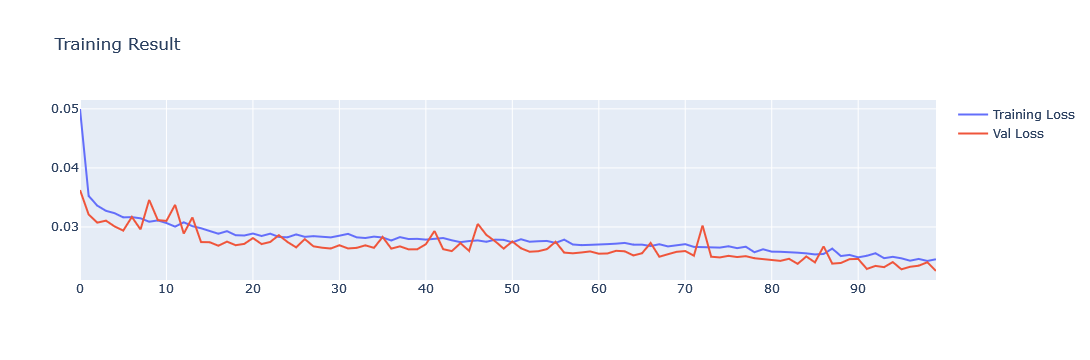

In [114]:
history4_lag30, model4_lag30 = run_model(model4_lag30, X_train_30, y_train_30, X_val_30, y_val_30, epochs=100)
plot_loss(history4_lag30, val_data=True)

In [115]:
y_pred2=model4_lag30.predict(X_val_30)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [116]:
from sklearn.metrics import r2_score
r2_score(y_val_30, y_pred2)

0.7198548399852446

In [ ]:
model4_lag30.save('models/model4_lag30.h5')

In [62]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load your dataset and split it into features (X) and target variable (y)
X_train =X_train_24
X_test=X_test_24 
y_train= y_train_24
y_test = y_test_24

# Choose a loss function and regularization technique
loss_function = 'squared_loss'  # MSE
regularization = 'ridge'  # Ridge Regression with L2 regularization

# Define the GRE model pipeline
if regularization == 'ridge':
    model = make_pipeline(StandardScaler(), Ridge(alpha=0.1))
elif regularization == 'lasso':
    model = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
elif regularization == 'elastic_net':
    model = make_pipeline(StandardScaler(), ElasticNet(alpha=0.1, l1_ratio=0.5))
else:
    raise ValueError("Invalid regularization option")

# Fit the GRE model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 0.00344709495659654
R-squared (R2) Score: 0.9392407692188085


In [63]:
# Load your dataset and split it into features (X) and target variable (y)
X_train =X_train_24
X_test=X_test_24 
y_train= y_train_24
y_test = y_test_24

# Choose a loss function and regularization technique
loss_function = 'squared_loss'  # MSE
regularization = 'lasso'  # Ridge Regression with L2 regularization

# Define the GRE model pipeline
if regularization == 'ridge':
    model = make_pipeline(StandardScaler(), Ridge(alpha=0.1))
elif regularization == 'lasso':
    model = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
elif regularization == 'elastic_net':
    model = make_pipeline(StandardScaler(), ElasticNet(alpha=0.1, l1_ratio=0.5))
else:
    raise ValueError("Invalid regularization option")

# Fit the GRE model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 0.016709896207585756
R-squared (R2) Score: 0.7054678061410622


In [64]:
# Load your dataset and split it into features (X) and target variable (y)
X_train =X_train_24
X_test=X_test_24 
y_train= y_train_24
y_test = y_test_24

# Choose a loss function and regularization technique
loss_function = 'squared_loss'  # MSE
regularization = 'elastic_net'  # Ridge Regression with L2 regularization

# Define the GRE model pipeline
if regularization == 'ridge':
    model = make_pipeline(StandardScaler(), Ridge(alpha=0.1))
elif regularization == 'lasso':
    model = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
elif regularization == 'elastic_net':
    model = make_pipeline(StandardScaler(), ElasticNet(alpha=0.1, l1_ratio=0.5))
else:
    raise ValueError("Invalid regularization option")

# Fit the GRE model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 0.008223390006046855
R-squared (R2) Score: 0.8550527741555265


In [66]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Define the GRE model pipeline
model = make_pipeline(StandardScaler(), Ridge(alpha=0.1))

# Reshape the data
X_train_reshaped = X_train_30.reshape(-1, 30)
y_train_reshaped = y_train_30.reshape(-1,)
X_test_reshaped = X_test_30.reshape(-1, 30)
y_test_reshaped = y_test_30.reshape(-1,)
X_val_reshaped = X_val_30.reshape(-1, 30)
y_val_reshaped = y_val_30.reshape(-1,)

# Fit the GRE model to the training data
model.fit(X_train_reshaped, y_train_reshaped)

# Make predictions on the test data
y_pred = model.predict(X_test_reshaped)

# Evaluate model performance
mse = mean_squared_error(y_test_reshaped, y_pred)
r2 = r2_score(y_test_reshaped, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 0.02951437046175207
R-squared (R2) Score: 0.6229335166975039
